<h1> Aunalytics Data Science Exercise, Part - I </h1>
<h2> Name: Prem Patel</h2>
<h2> Date: 04/25/2021 </h2>

<b>Objective:</b> The prediction task is to determine whether a person makes over 50K a year. Explain the performance of the model using accuracy, AUROC curve and confusion matrix. Feel free to add any other metric you see fit.


In [156]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_curve, confusion_matrix, f1_score, roc_auc_score
from sklearn.preprocessing import binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree

%matplotlib inline

In [157]:
# reading data
test = pd.read_csv("au_test.csv")
train = pd.read_csv("au_train.csv")

# Temporarily merging the data
df = test.append(train)

# dimension of the df
print("Test data shape: ", test.shape)
print("Train data shape: ", train.shape)

df.head()

Test data shape:  (16281, 15)
Train data shape:  (32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


<h2> 1. Preprocessing and preparing data </h2>

In [158]:
# trimming white spaces of all columns with strings (sanity check)
test = test.applymap(lambda x: x.strip() if isinstance(x, str) else x)
train = train.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# converting  "?" to N/A values
test = test.replace('?', np.NaN)
train = train.replace('?', np.NaN)

# number of null values
print("Number of rows in test with NaN: ",test.isnull().values.ravel().sum())
print("Number of rows in train with NaN: ",train.isnull().values.ravel().sum())

Number of rows in test with NaN:  2203
Number of rows in train with NaN:  4262


<h4>There are 6465 rows in total with NaN values, i.e. ~7% of the total rows so we can drop these rows<h4>

In [159]:
test = test.dropna()
train = train.dropna()
print("New data shape of test: ", test.shape)
print("New data shape of train: ", train.shape)

New data shape of test:  (15060, 15)
New data shape of train:  (30162, 15)


In [160]:
# describing numerical columns
train.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,30162.000000,3.016200e+04,30162.000000,30162.000000,30162.000000,30162.000000
mean,38.437902,1.897938e+05,10.121312,1092.007858,88.372489,40.931238
std,13.134665,1.056530e+05,2.549995,7406.346497,404.298370,11.979984
min,17.000000,1.376900e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.176272e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.784250e+05,10.000000,0.000000,0.000000,40.000000
75%,47.000000,2.376285e+05,13.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


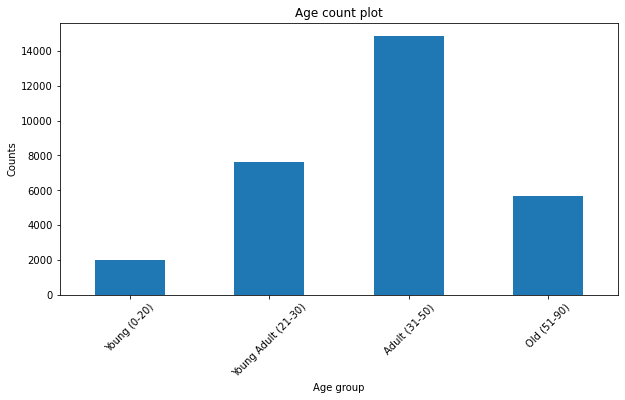

In [161]:
# changing age into a categorical variable

bins = [0,20,30,50,90]
group_names = ['Young (0-20)','Young Adult (21-30)','Adult (31-50)','Old (51-90)']

test['age_categ'] = pd.cut(test['age'], bins, labels=group_names)
train['age_categ'] = pd.cut(train['age'], bins, labels=group_names)

# plotting age for train
ax = train['age_categ'].value_counts().sort_index().plot(kind='bar',figsize=(10,5),title="Age count plot")
ax.set_xlabel("Age group")
ax.set_ylabel("Counts")
plt.xticks(rotation = 45)
plt.show()


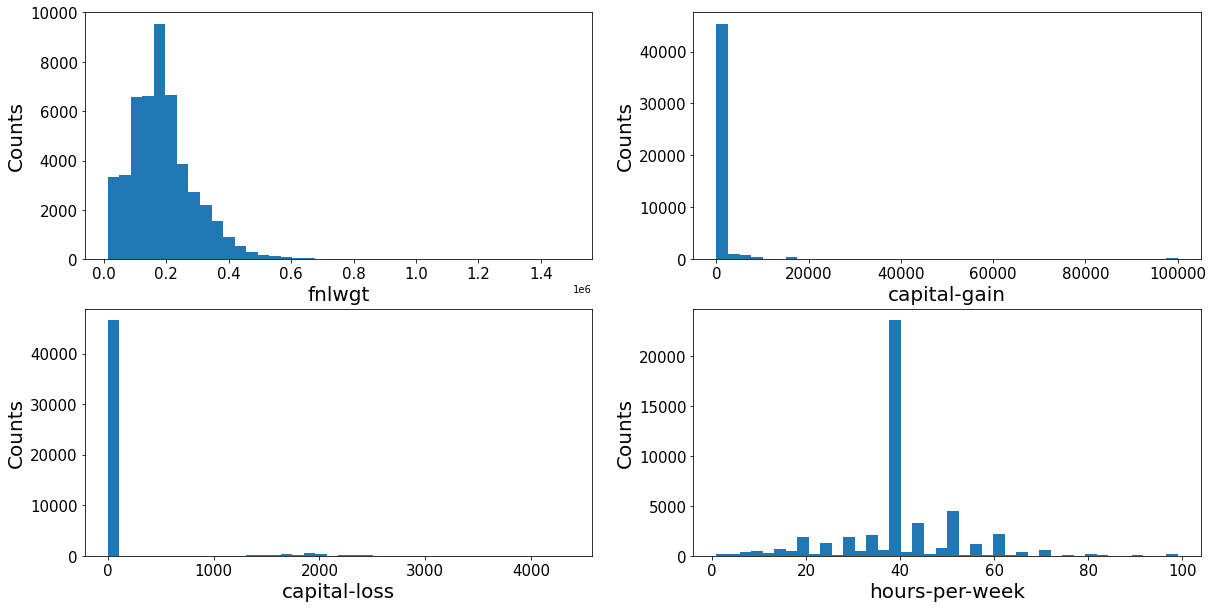

In [162]:
plt.rcParams['figure.figsize'] = (20, 10)

# make subplots
fig, axes = plt.subplots(nrows = 2, ncols = 2)

# specify the features of interest
num_features = ['fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week']
xaxes = num_features
yaxes = ['Counts', 'Counts', 'Counts', 'Counts']

# plot histograms
axes = axes.ravel()
for idx, ax in enumerate(axes):
    ax.hist(df[num_features[idx]].dropna(), bins=40)
    ax.set_xlabel(xaxes[idx], fontsize=20)
    ax.set_ylabel(yaxes[idx], fontsize=20)
    ax.tick_params(axis='both', labelsize=15)

<h4>Since there is major skewness in 'fnlwgt', 'capital-gain', 'capital-loss', and 'hours-per-week'.
We will try to categorize  them or remove the variable<h4>

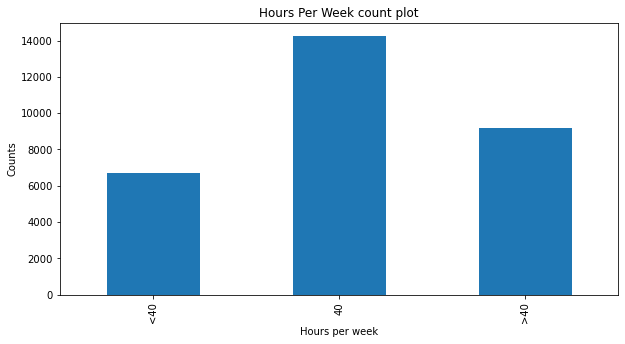

In [163]:
# categorizing 'hours-per-week'
bins = [0,39,40,99]
group_names = ['<40','40','>40']

test['hours_per_week_categ'] = pd.cut(test['hours-per-week'], bins, labels=group_names)
train['hours_per_week_categ'] = pd.cut(train['hours-per-week'], bins, labels=group_names)

# plotting hours_per_week_categ for train
ax = train['hours_per_week_categ'].value_counts().sort_index().plot(kind='bar',
                                                                    figsize=(10,5),title="Hours Per Week count plot")
ax.set_xlabel("Hours per week")
ax.set_ylabel("Counts")
plt.show()

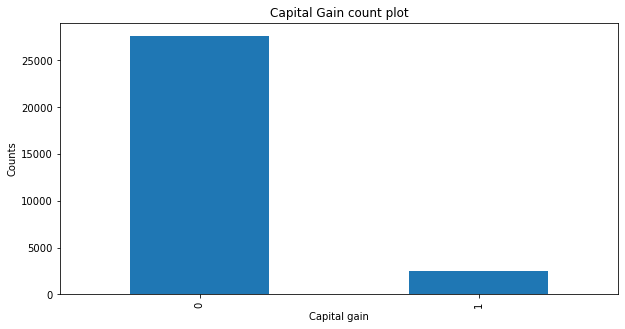

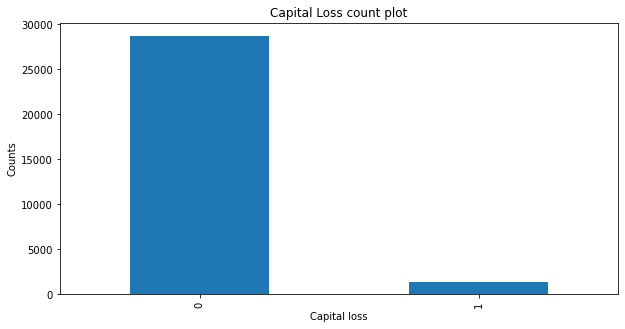

In [164]:
# converting capital loss and capital gain into 0 and 1 

train['new_capital-loss'] = [0 if capital==0 else 1 for capital in train['capital-loss']]
train['new_capital-gain'] = [0 if capital==0 else 1 for capital in train['capital-gain']]

test['new_capital-loss'] = [0 if capital==0 else 1 for capital in test['capital-loss']]
test['new_capital-gain'] = [0 if capital==0 else 1 for capital in test['capital-gain']]

# plotting capital_grain for train
ax = train['new_capital-gain'].value_counts().sort_index().plot(kind='bar',
                                                                    figsize=(10,5),title="Capital Gain count plot")
ax.set_xlabel("Capital gain")
ax.set_ylabel("Counts")
plt.show()

ax = train['new_capital-loss'].value_counts().sort_index().plot(kind='bar',
                                                                    figsize=(10,5),title="Capital Loss count plot")
ax.set_xlabel("Capital loss")
ax.set_ylabel("Counts")
plt.show()

<h4> We will drop 'fnlwgt' because of abiguity of this variable and skewness </h4>

In [165]:
# describing categorical columns
train.describe(include=['O'])

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,class
count,30162,30162,30162,30162,30162,30162,30162,30162,30162
unique,7,16,7,14,6,5,2,41,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22286,9840,14065,4038,12463,25933,20380,27504,22654


In [166]:
# Creating frequency tables for categorical columns

print(train['workclass'].value_counts())
print(train['education'].value_counts())
print(train['marital-status'].value_counts())
print(train['occupation'].value_counts())
print(train['relationship'].value_counts())
print(train['race'].value_counts())
print(train['sex'].value_counts())
print(train['native-country'].value_counts())
print(train['class'].value_counts())

Private             22286
Self-emp-not-inc     2499
Local-gov            2067
State-gov            1279
Self-emp-inc         1074
Federal-gov           943
Without-pay            14
Name: workclass, dtype: int64
HS-grad         9840
Some-college    6678
Bachelors       5044
Masters         1627
Assoc-voc       1307
11th            1048
Assoc-acdm      1008
10th             820
7th-8th          557
Prof-school      542
9th              455
12th             377
Doctorate        375
5th-6th          288
1st-4th          151
Preschool         45
Name: education, dtype: int64
Married-civ-spouse       14065
Never-married             9726
Divorced                  4214
Separated                  939
Widowed                    827
Married-spouse-absent      370
Married-AF-spouse           21
Name: marital-status, dtype: int64
Prof-specialty       4038
Craft-repair         4030
Exec-managerial      3992
Adm-clerical         3721
Sales                3584
Other-service        3212
Machine-op-ins

As we can observe from the frequency table above, there are certain variables which can use merging their variables to reduce complexity and improve model's efficiency.

The variables choosen to merge are 'workclass', and 'marital-status'

While 'country' variable can be ignored because of skewness in the data distribution.

'class' variable also needs to be fixed since there are repeating categories with just different names

<h2>2. Feature Engineering</h2>

0    22654
1     7508
Name: class, dtype: int64


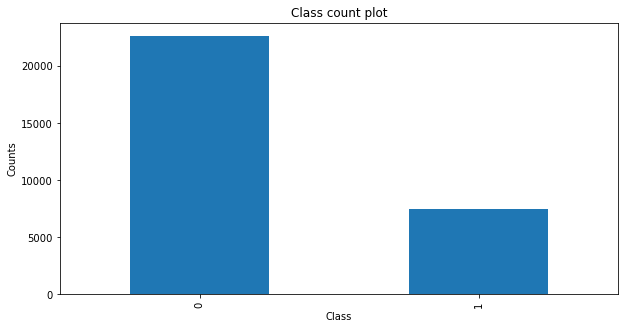

In [167]:
# sanitizing target variable
# since we have 4 categorical values in 'class', we will fix the typos and convert it to 0 and 1

train["class"] = train["class"].replace('<=50K.', '0')
train["class"] = train["class"].replace('>50K.', '1')
train["class"] = train["class"].replace('<=50K', '0')
train["class"] = train["class"].replace('>50K', '1')

test["class"] = test["class"].replace('<=50K.', '0')
test["class"] = test["class"].replace('>50K.', '1')
test["class"] = test["class"].replace('<=50K', '0')
test["class"] = test["class"].replace('>50K', '1')

# confirming the fix in class category
print(train['class'].value_counts())

# plotting number of classes (dependent variable)
ax = train['class'].value_counts().sort_index().plot(kind='bar', figsize=(10,5),title="Class count plot")
ax.set_xlabel("Class")
ax.set_ylabel("Counts")
plt.show()

Due to the number of positive classes being less than 50% of negatives, we will perform <b>Under Sampling</b> to improve accuracy and reduce computational cost as well.

In [168]:
# merging categories in 'workclass'

test['new_workclass'] = test['workclass']
test['new_workclass'].replace({'Local-gov':'Gov','State-gov':'Gov','Federal-gov':'Gov',
                             'Self-emp-not-inc':'Self-emp','Self-emp-inc':'Self-emp'}, inplace=True)

train['new_workclass'] = train['workclass']
train['new_workclass'].replace({'Local-gov':'Gov','State-gov':'Gov','Federal-gov':'Gov',
                             'Self-emp-not-inc':'Self-emp','Self-emp-inc':'Self-emp'}, inplace=True)
print(train['new_workclass'].value_counts())

Private        22286
Gov             4289
Self-emp        3573
Without-pay       14
Name: new_workclass, dtype: int64


In [169]:
# merging categories in 'occupation'

test['new_marital-status'] = test['marital-status']
test['new_marital-status'].replace({'Married-civ-spouse':'Married','Married-spouse-absent':'Married',
                                  'Married-AF-spouse':'Married'}, inplace=True)

train['new_marital-status'] = train['marital-status']
train['new_marital-status'].replace({'Married-civ-spouse':'Married','Married-spouse-absent':'Married',
                                  'Married-AF-spouse':'Married'}, inplace=True)
print(train['new_marital-status'].value_counts())

Married          14456
Never-married     9726
Divorced          4214
Separated          939
Widowed            827
Name: new_marital-status, dtype: int64


In [170]:
# merging non USA countries to one in 'native-country'

test['native-country'] = ['Non-USA' if country!= 'United-States' else 'United-States' 
                          for country in test['native-country']]
train['native-country'] = ['Non-USA' if country!= 'United-States' else 'United-States' 
                          for country in train['native-country']]

train['native-country'].unique()

array(['United-States', 'Non-USA'], dtype=object)

In [171]:
train.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'class', 'age_categ', 'hours_per_week_categ', 'new_capital-loss',
       'new_capital-gain', 'new_workclass', 'new_marital-status'],
      dtype='object')

In [172]:
# dropping unnecessarily/repetitive variables

to_drop = ['age','workclass','fnlwgt','education','marital-status','capital-gain','capital-loss','hours-per-week']

train = train.drop(to_drop,axis=1)
test = test.drop(to_drop,axis=1)

# reorder columns for convenience
train = train[['age_categ','new_workclass','education-num','new_marital-status','occupation', 'relationship', 'race', 'sex',
       'native-country', 'hours_per_week_categ','class']]
test = test[['age_categ','new_workclass','education-num','new_marital-status','occupation', 'relationship', 'race', 'sex',
       'native-country', 'hours_per_week_categ','class']]

train.columns

Index(['age_categ', 'new_workclass', 'education-num', 'new_marital-status',
       'occupation', 'relationship', 'race', 'sex', 'native-country',
       'hours_per_week_categ', 'class'],
      dtype='object')

In [173]:
# hot one encoding for the rest of the categorical variables

cat_columns = ['age_categ', 'new_workclass', 'new_marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country','hours_per_week_categ']
train = pd.get_dummies(train, prefix_sep="__", columns = cat_columns)
test = pd.get_dummies(test, prefix_sep="__", columns = cat_columns)

In [174]:
# Splitting data and undersampling train to remove skewness in class variable

# undersampling

train_samples_0 = train[train['class']=='0']
train_samples_1 = train[train['class']=='1']
X_split_1, X_split_2 = train_test_split(train_samples_0, test_size=0.33, random_state=0)

train_undersampled = pd.concat([X_split_2,train_samples_1])

print(train_undersampled['class'].value_counts())

X_train = train_undersampled.drop(['class'],axis = 1, inplace=False)
y_train = train_undersampled['class']

X_train_beforeUnderSample = train.drop(['class'], axis = 1, inplace=False)
y_train_beforeUnderSample = train['class']

X_test = test.drop(['class'],axis=1, inplace=False)
y_test = test['class']

1    7508
0    7476
Name: class, dtype: int64


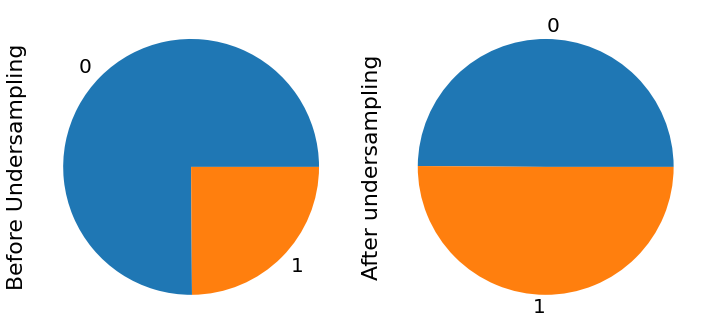

In [175]:
# before and after undersampling pie chart

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

train.groupby('class').size().plot(kind='pie', textprops={'fontsize': 20}, ax=ax1)
train_undersampled.groupby('class').size().plot(kind='pie', textprops={'fontsize': 20}, ax=ax2)

ax1.set_ylabel('Before Undersampling', size=22)
ax2.set_ylabel('After undersampling', size=22)
plt.tight_layout()

The <b>accuracy for models might reduce</b> but we will get <b>better F-1 scores</b> and similar AUCROC curve results, which seems to be better metrics in a case where the original data consists of a skewed dependent variable.

<h2> 3. Model Building </h2>

<h3>Logistic Regression</h3>

Classification Report of LR: 
               precision    recall  f1-score   support

           0       0.94      0.76      0.84     11360
           1       0.54      0.85      0.66      3700

    accuracy                           0.78     15060
   macro avg       0.74      0.81      0.75     15060
weighted avg       0.84      0.78      0.80     15060


 Accuracy_score of LR: 0.7827357237715803

 Confusion Matrix of LR: 
 [[8642 2718]
 [ 554 3146]]


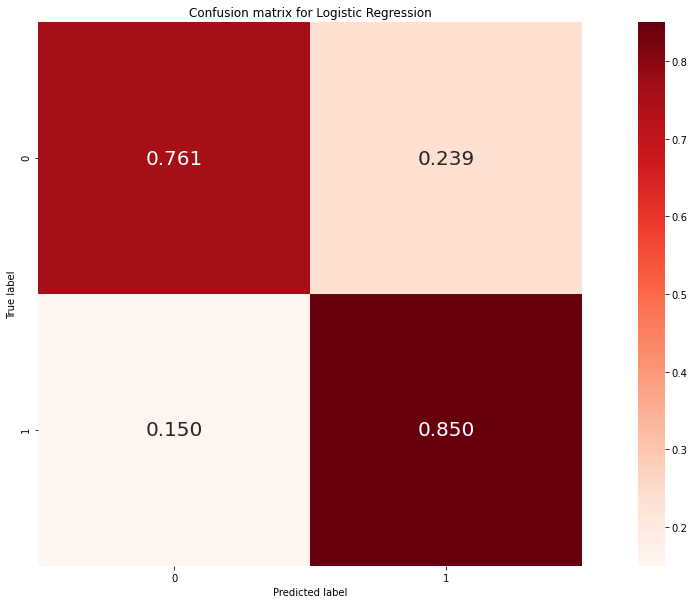

In [176]:
lr = LogisticRegression(solver='lbfgs', max_iter=1000)

lr.fit(X_train,y_train)
y_pred_lr = lr.predict(X_test)

print("Classification Report of LR: \n", classification_report(y_test, y_pred_lr))
print('\n Accuracy_score of LR:', accuracy_score(y_test, y_pred_lr))

print("\n Confusion Matrix of LR: \n", confusion_matrix(y_test, y_pred_lr))

# for plotting confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_lr = cm_lr.astype('float') / cm_lr.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_lr, annot=True, annot_kws={"size":20}, cmap='Reds', square=True, fmt='.3f')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for Logistic Regression');

<h3>KNN (k-Nearest Neighbors)</h3>

Text(0, 0.5, 'Testing Accuracy')

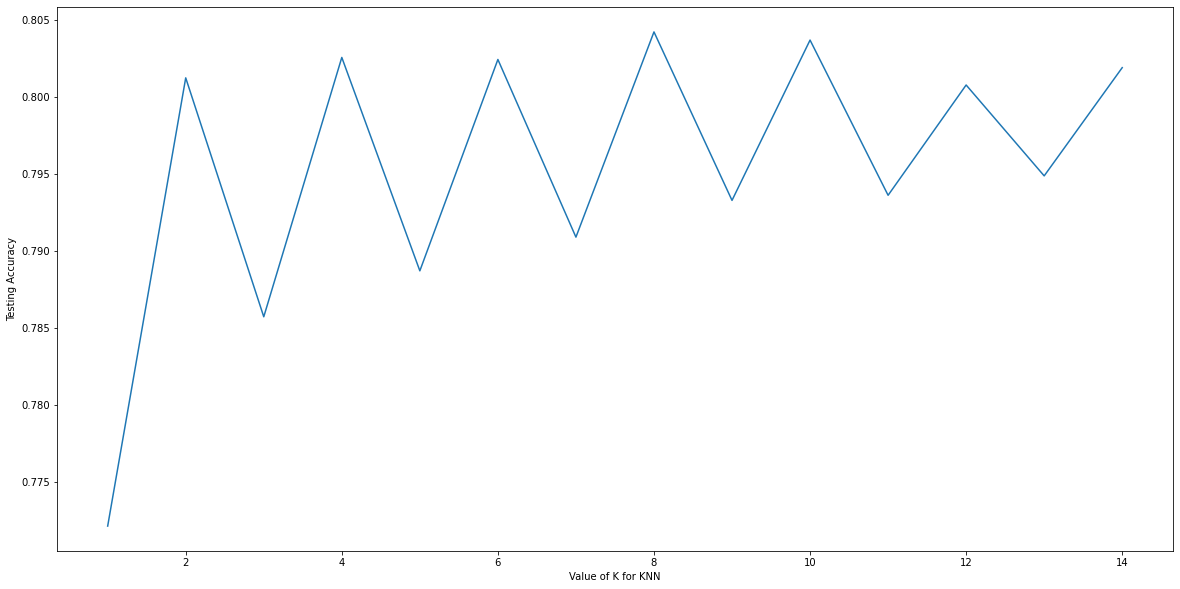

In [177]:
# Plotting a different range of k values to find the optimal one

k_range = range(1,15)
scores = {}
scores_list = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_test)
    scores[k] = metrics.accuracy_score(y_test,y_pred)
    scores_list.append(metrics.accuracy_score(y_test,y_pred))
    
plt.plot(k_range,scores_list)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.85      0.87     11360
           1       0.59      0.67      0.63      3700

    accuracy                           0.80     15060
   macro avg       0.74      0.76      0.75     15060
weighted avg       0.81      0.80      0.81     15060


 Final KNN Accuracy Score:  0.8042496679946879

 Confusion Matrix: 
 [[9639 1721]
 [1227 2473]]


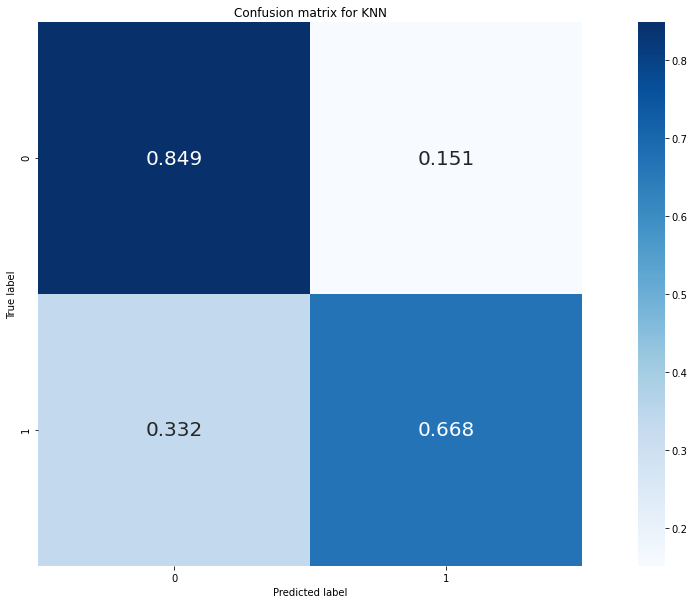

In [178]:
# there is no significant improvement after k = 8 so we will fit the model using k = 8 for final scores
knn = KNeighborsClassifier(n_neighbors = 8)

knn.fit(X_train,y_train)
y_pred_knn = knn.predict(X_test)

print("Classification Report: \n",classification_report(y_test, y_pred_knn))
print("\n Final KNN Accuracy Score: ", metrics.accuracy_score(y_test,y_pred_knn))
print("\n Confusion Matrix: \n", confusion_matrix(y_test, y_pred_knn))

# for plotting confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_knn = cm_knn.astype('float') / cm_knn.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_knn, annot=True, annot_kws={"size":20}, cmap='Blues', square=True, fmt='.3f')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for KNN');

<h3> AdaBoost Classifier </h3>

Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.76      0.84     11360
           1       0.54      0.84      0.66      3700

    accuracy                           0.78     15060
   macro avg       0.74      0.80      0.75     15060
weighted avg       0.84      0.78      0.80     15060


 Final KNN Accuracy Score:  0.7841301460823373

 Confusion Matrix: 
 [[8684 2676]
 [ 575 3125]]


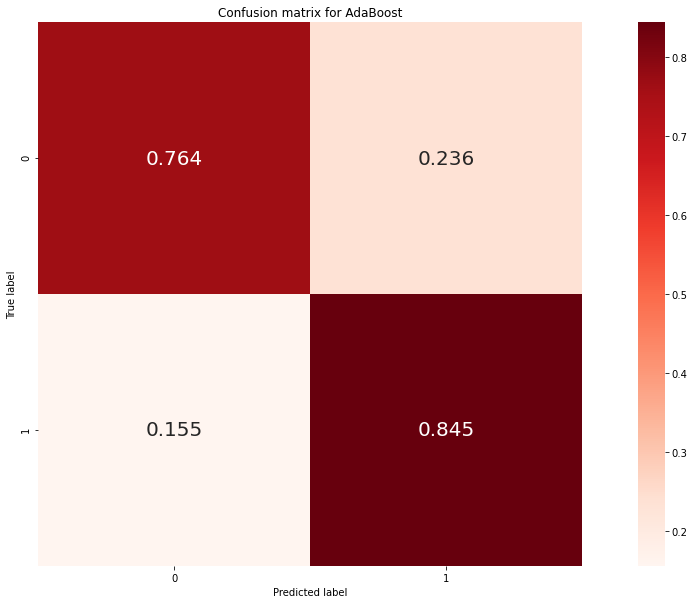

In [179]:
ab = AdaBoostClassifier(n_estimators=100, random_state=0)
ab.fit(X_train,y_train)

y_pred_ab = ab.predict(X_test)

print("Classification Report: \n",classification_report(y_test, y_pred_ab))
print("\n Final KNN Accuracy Score: ", metrics.accuracy_score(y_test,y_pred_ab))
print("\n Confusion Matrix: \n", confusion_matrix(y_test, y_pred_ab))

# for plotting confusion matrix
cm_ab = confusion_matrix(y_test, y_pred_ab)
cm_ab = cm_ab.astype('float') / cm_ab.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_ab, annot=True, annot_kws={"size":20}, cmap='Reds', square=True, fmt='.3f')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for AdaBoost');

<h3>Decision Tree</h3>

Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.74      0.82     11360
           1       0.50      0.80      0.61      3700

    accuracy                           0.75     15060
   macro avg       0.71      0.77      0.71     15060
weighted avg       0.81      0.75      0.77     15060


 Final DT Accuracy Score:  0.751195219123506

 Confusion Matrix: 
 [[8360 3000]
 [ 747 2953]]


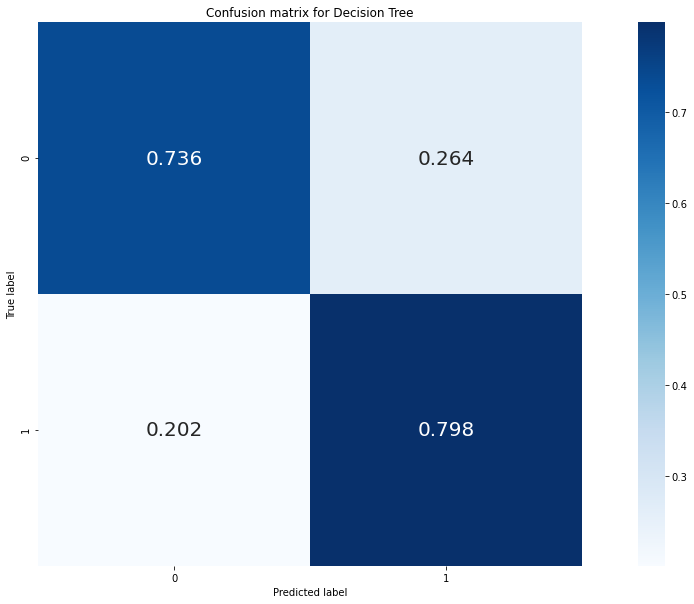

In [180]:
dt = tree.DecisionTreeClassifier()
dt = dt.fit(X_train,y_train)

y_pred_dt = dt.predict(X_test)

print("Classification Report: \n",classification_report(y_test, y_pred_dt))
print("\n Final DT Accuracy Score: ", metrics.accuracy_score(y_test,y_pred_dt))
print("\n Confusion Matrix: \n", confusion_matrix(y_test, y_pred_dt))

# for plotting confusion matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)
cm_dt = cm_dt.astype('float') / cm_dt.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_dt, annot=True, annot_kws={"size":20}, cmap='Blues', square=True, fmt='.3f')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for Decision Tree');

<h3> Plotting ROC curves and calculating AUC ROC </h3>

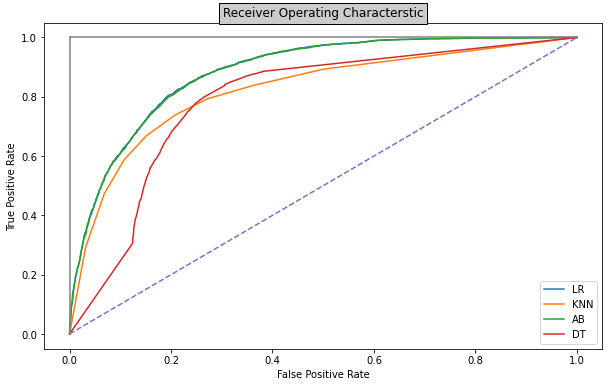

AUC ROC of Logistic Regression:  0.8835389703083366
AUC ROC of KNN:  0.8219080343547773
AUC ROC of Ada Boost:  0.8828336386562619
AUC ROC of Decision Tree:  0.7907862461933765


In [181]:
# Plotting all ROC Curves

y_test_int = [int(x) for x in y_test]

# probability calculation
y_score_lr = lr.predict_proba(X_test)[:,1]
y_score_knn = knn.predict_proba(X_test)[:,1]
y_score_ab = ab.predict_proba(X_test)[:,1]
y_score_dt = dt.predict_proba(X_test)[:,1]

# ROC calculation
false_positive_rate_lr, true_positive_rate_lr, threshold_lr = roc_curve(y_test_int, y_score_lr)
false_positive_rate_knn, true_positive_rate_knn, threshold_knn = roc_curve(y_test_int, y_score_knn)
false_positive_rate_ab, true_positive_rate_ab, threshold_ab = roc_curve(y_test_int, y_score_ab)
false_positive_rate_dt, true_positive_rate_dt, threshold_dt = roc_curve(y_test_int, y_score_dt)

plt.figure(figsize=(10,6))
plt.title('Receiver Operating Characterstic', bbox={'facecolor':'0.8'})

# plotting
plt.plot(false_positive_rate_lr,true_positive_rate_lr, label= "LR")
plt.plot(false_positive_rate_knn,true_positive_rate_knn, label= "KNN")
plt.plot(false_positive_rate_ab,true_positive_rate_ab, label= "AB")
plt.plot(false_positive_rate_dt,true_positive_rate_dt, label= "DT")

plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.show()

print("AUC ROC of Logistic Regression: ", roc_auc_score(y_test, y_score_lr))
print("AUC ROC of KNN: ", roc_auc_score(y_test, y_score_knn))
print("AUC ROC of Ada Boost: ", roc_auc_score(y_test, y_score_ab))
print("AUC ROC of Decision Tree: ", roc_auc_score(y_test, y_score_dt))

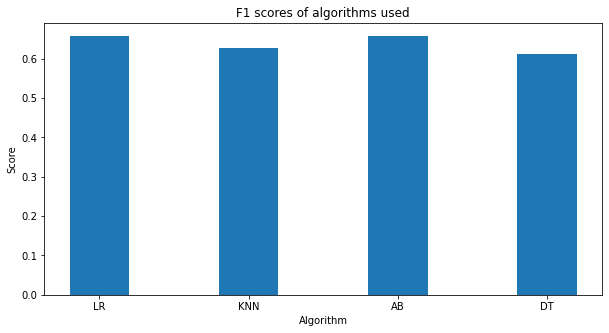

F1_score of Logistic Regression:  0.657883730656629
F1_score of KNN:  0.6265518115024068
F1_score of Ada Boost:  0.657825492053468
F1_score of Decision Tree:  0.6118305190096343


In [182]:
# F1 scores:

# calculation
f1_lr = f1_score(y_test.astype(int),y_pred_lr.astype(int))
f1_knn = f1_score(y_test.astype(int),y_pred_knn.astype(int))
f1_ab = f1_score(y_test.astype(int),y_pred_ab.astype(int))
f1_dt = f1_score(y_test.astype(int),y_pred_dt.astype(int))

f1_scores = {'LR':f1_lr, 'KNN':f1_knn, 'AB':f1_ab, 'DT':f1_dt}
algo = list(f1_scores.keys())
score = list(f1_scores.values())

# plotting
fig = plt.figure(figsize = (10, 5))
plt.bar(algo, score, width = 0.4)
plt.xlabel("Algorithm")
plt.ylabel("Score")
plt.title("F1 scores of algorithms used")
plt.show()

print('F1_score of Logistic Regression: ', f1_lr)
print('F1_score of KNN: ', f1_knn)
print('F1_score of Ada Boost: ', f1_ab)
print('F1_score of Decision Tree: ', f1_dt)

# plot



<h2> 4. Results: </h2>

From above observations and according to AUC ROC, accuracy, and F-1 scores, <b>Logistic Regression</b> and <b> Ada Boost </b>are the best algorithms to predict if a person earns over 50K per year.